The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


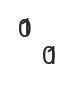

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [74]:
from torch.utils.data.sampler import SequentialSampler
from src.models import FullTCRVAE
model = FullTCRVAE(0, 0,22, 0, 0, 23, 'BL50LO', hidden_dim=64, latent_dim=32)
df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
df['set'] = df['partition'].apply(lambda x: 'valid' if x==0 else 'train')
dataset = TCRSpecificDataset(df, 0, 0, 22, 0, 0, 23, 'BL50LO', 
                              -20,'A1', 'A2', 'A3', 'B1', 'B2', 'B3')
loader = dataset.get_dataloader(1024, SequentialSampler)
model = load_checkpoint(model, '../output/TripletTest/231108_FirstTestTriplet_A3B3_Euclidean_margin_Auto_15k_epochs_5U0XJ/231108_FirstTestTriplet_A3B3_margin_Auto_15k_epochs_KFold_0_231109_1016_5U0XJ/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_FirstTestTriplet_A3B3_margin_Auto_15k_epochs_KFold_0_231109_1016_5U0XJ.pt')
model.eval()
preds = predict_model(model, dataset, loader)

Reloading best model:
Best epoch: 2978
total: 0.3471359203992122
reconstruction: 0.3236078183448857
kld: 0.011238383888040365
triplet: 0.012289712281555546
seq_accuracy: 0.7950296401977539
v_accuracy: 0
j_accuracy: 0
here
here
here
here
here
here
here
here
here
here
here
here
here
here


In [93]:
model2 = FullTCRVAE(0, 0,22, 0, 0, 23, 'BL50LO', hidden_dim=64, latent_dim=32)
preds2 = predict_model(model2, dataset, loader)
z2 = torch.from_numpy(preds2[zcols].values)

In [103]:
dot = torch.mm(z2, z2.t())
norms = torch.norm(z2, p=2, dim=1, keepdim=True)
norm2 = norms * norms.t()

In [139]:
from src.metrics import compute_cosine_distance
cos2 = compute_cosine_distance(z2)
cos = compute_cosine_distance(z)
cos2[:5, :5]

tensor([[0.0000, 0.3473, 0.2778, 0.2894, 0.9475],
        [0.3473, 0.0000, 0.6491, 0.3513, 0.7533],
        [0.2778, 0.6491, 0.0000, 0.2269, 0.9140],
        [0.2894, 0.3513, 0.2269, 0.0000, 0.6336],
        [0.9475, 0.7533, 0.9140, 0.6336, 0.0000]])

In [140]:
cos[:5, :5]

tensor([[0.0000, 0.1913, 0.3260, 0.2627, 0.1818],
        [0.1913, 0.0000, 0.1253, 0.1367, 0.1319],
        [0.3260, 0.1253, 0.0000, 0.1269, 0.1726],
        [0.2627, 0.1367, 0.1269, 0.0000, 0.1350],
        [0.1818, 0.1319, 0.1726, 0.1350, 0.0000]])

In [116]:
# Set values less than or equal to 1e-5 to 0
cos2[cos2 <= 1e-5] = 0

# Clamp values to be between 0 and 1
cos2 = torch.clamp(cos2, 0, 1)

In [120]:
manual_cos[manual_cos>1]

tensor([1.0161, 1.0551, 1.0719,  ..., 1.0069, 1.0090, 1.0113])

In [119]:
manual_cos = 1 - (dot / norm2)
manual_cos.max(), manual_cos.min(), manual_cos.median(), manual_cos.mean(), manual_cos.std()

(tensor(1.8429),
 tensor(-1.1921e-07),
 tensor(0.5633),
 tensor(0.6015),
 tensor(0.2607))

In [125]:
def tensor_stats(tensor):
    print(f'max: {tensor.max():.3e}, min: {tensor.min():.3e}, mean: {tensor.mean():.3e}, med: {tensor.median():.3e}, std: {tensor.std():.3e}')
    

In [126]:
tensor_stats(cos)

max: 7.337e-01, min: -1.192e-07, mean: 1.926e-01, med: 1.861e-01, std: 6.693e-02


In [127]:
compute_cosine_distance(z, z, p=2)

tensor([[ 1.1921e-07,  1.9134e-01,  3.2602e-01,  ...,  8.7775e-02,
          8.7753e-02,  1.1952e-01],
        [ 1.9134e-01,  0.0000e+00,  1.2531e-01,  ...,  1.8682e-01,
          1.5491e-01,  2.1118e-01],
        [ 3.2602e-01,  1.2531e-01, -1.1921e-07,  ...,  2.9627e-01,
          2.5814e-01,  3.4465e-01],
        ...,
        [ 8.7775e-02,  1.8682e-01,  2.9627e-01,  ...,  0.0000e+00,
          4.0389e-02,  1.4842e-01],
        [ 8.7753e-02,  1.5491e-01,  2.5814e-01,  ...,  4.0389e-02,
          0.0000e+00,  1.4157e-01],
        [ 1.1952e-01,  2.1118e-01,  3.4465e-01,  ...,  1.4842e-01,
          1.4157e-01,  0.0000e+00]])

In [119]:
manual_cos = 1 - (dot / norm2)
manual_cos.max(), manual_cos.min(), manual_cos.median(), manual_cos.mean(), manual_cos.std()

(tensor(1.8429),
 tensor(-1.1921e-07),
 tensor(0.5633),
 tensor(0.6015),
 tensor(0.2607))

In [110]:
pd.DataFrame(cos2)[range(10)].describe()

,0,1,2,3,4,5,6,7,8,9
count,6.353000e+03,6353.000000,6.353000e+03,6353.000000,6.353000e+03,6353.000000,6.353000e+03,6.353000e+03,6.353000e+03,6353.000000
mean,5.186962e-01,0.517967,5.372647e-01,0.484381,8.233352e-01,0.573597,5.641522e-01,5.747511e-01,6.237338e-01,0.578345
std,1.613321e-01,0.147199,1.742908e-01,0.143024,4.112997e-01,0.235941,2.690619e-01,1.321101e-01,2.855053e-01,0.158008
min,-1.192093e-07,0.000000,1.192093e-07,0.000000,1.192093e-07,0.000000,1.192093e-07,5.960464e-08,5.960464e-08,0.000000
25%,3.981333e-01,0.410297,4.070694e-01,0.379141,4.841430e-01,0.389547,3.445272e-01,4.807523e-01,3.871662e-01,0.465400
50%,4.947702e-01,0.515969,5.147728e-01,0.473621,8.087338e-01,0.534148,5.148104e-01,5.719835e-01,5.926954e-01,0.553510
75%,6.212136e-01,0.622212,6.477591e-01,0.578828,1.159658e+00,0.728963,7.463725e-01,6.672796e-01,8.396362e-01,0.672752
max,1.160918e+00,1.127093,1.282438e+00,1.036864,1.740401e+00,1.417287,1.398061e+00,1.007913e+00,1.427207e+00,1.154190


In [75]:
zcols = [x for x in train_preds.columns if x.startswith('z_')]
z = torch.from_numpy(preds[zcols].values)
dists = torch.cdist(z,z)
dist_matrix = pd.DataFrame(dists, 
                           columns = [x['A3']+'-'+x['B3'] for _, x in preds.iterrows()],
                           index = [x['A3']+'-'+x['B3'] for _, x in preds.iterrows()])
dist_matrix['set'] = df['set'].values
dist_matrix['label'] = df['peptide'].values
dist_matrix['binder'] = df['binder'].values
dist_matrix['origin'] = df['origin'].values

## Plot DF

In [88]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=2000, metric='euclidean', perplexity=30)
latent_tsne = tsne.fit_transform(z)

In [89]:
from umap import UMAP
umap = UMAP(n_components=2, n_epochs=500, learning_rate=0.79)
latent_umap = umap.fit_transform(z)

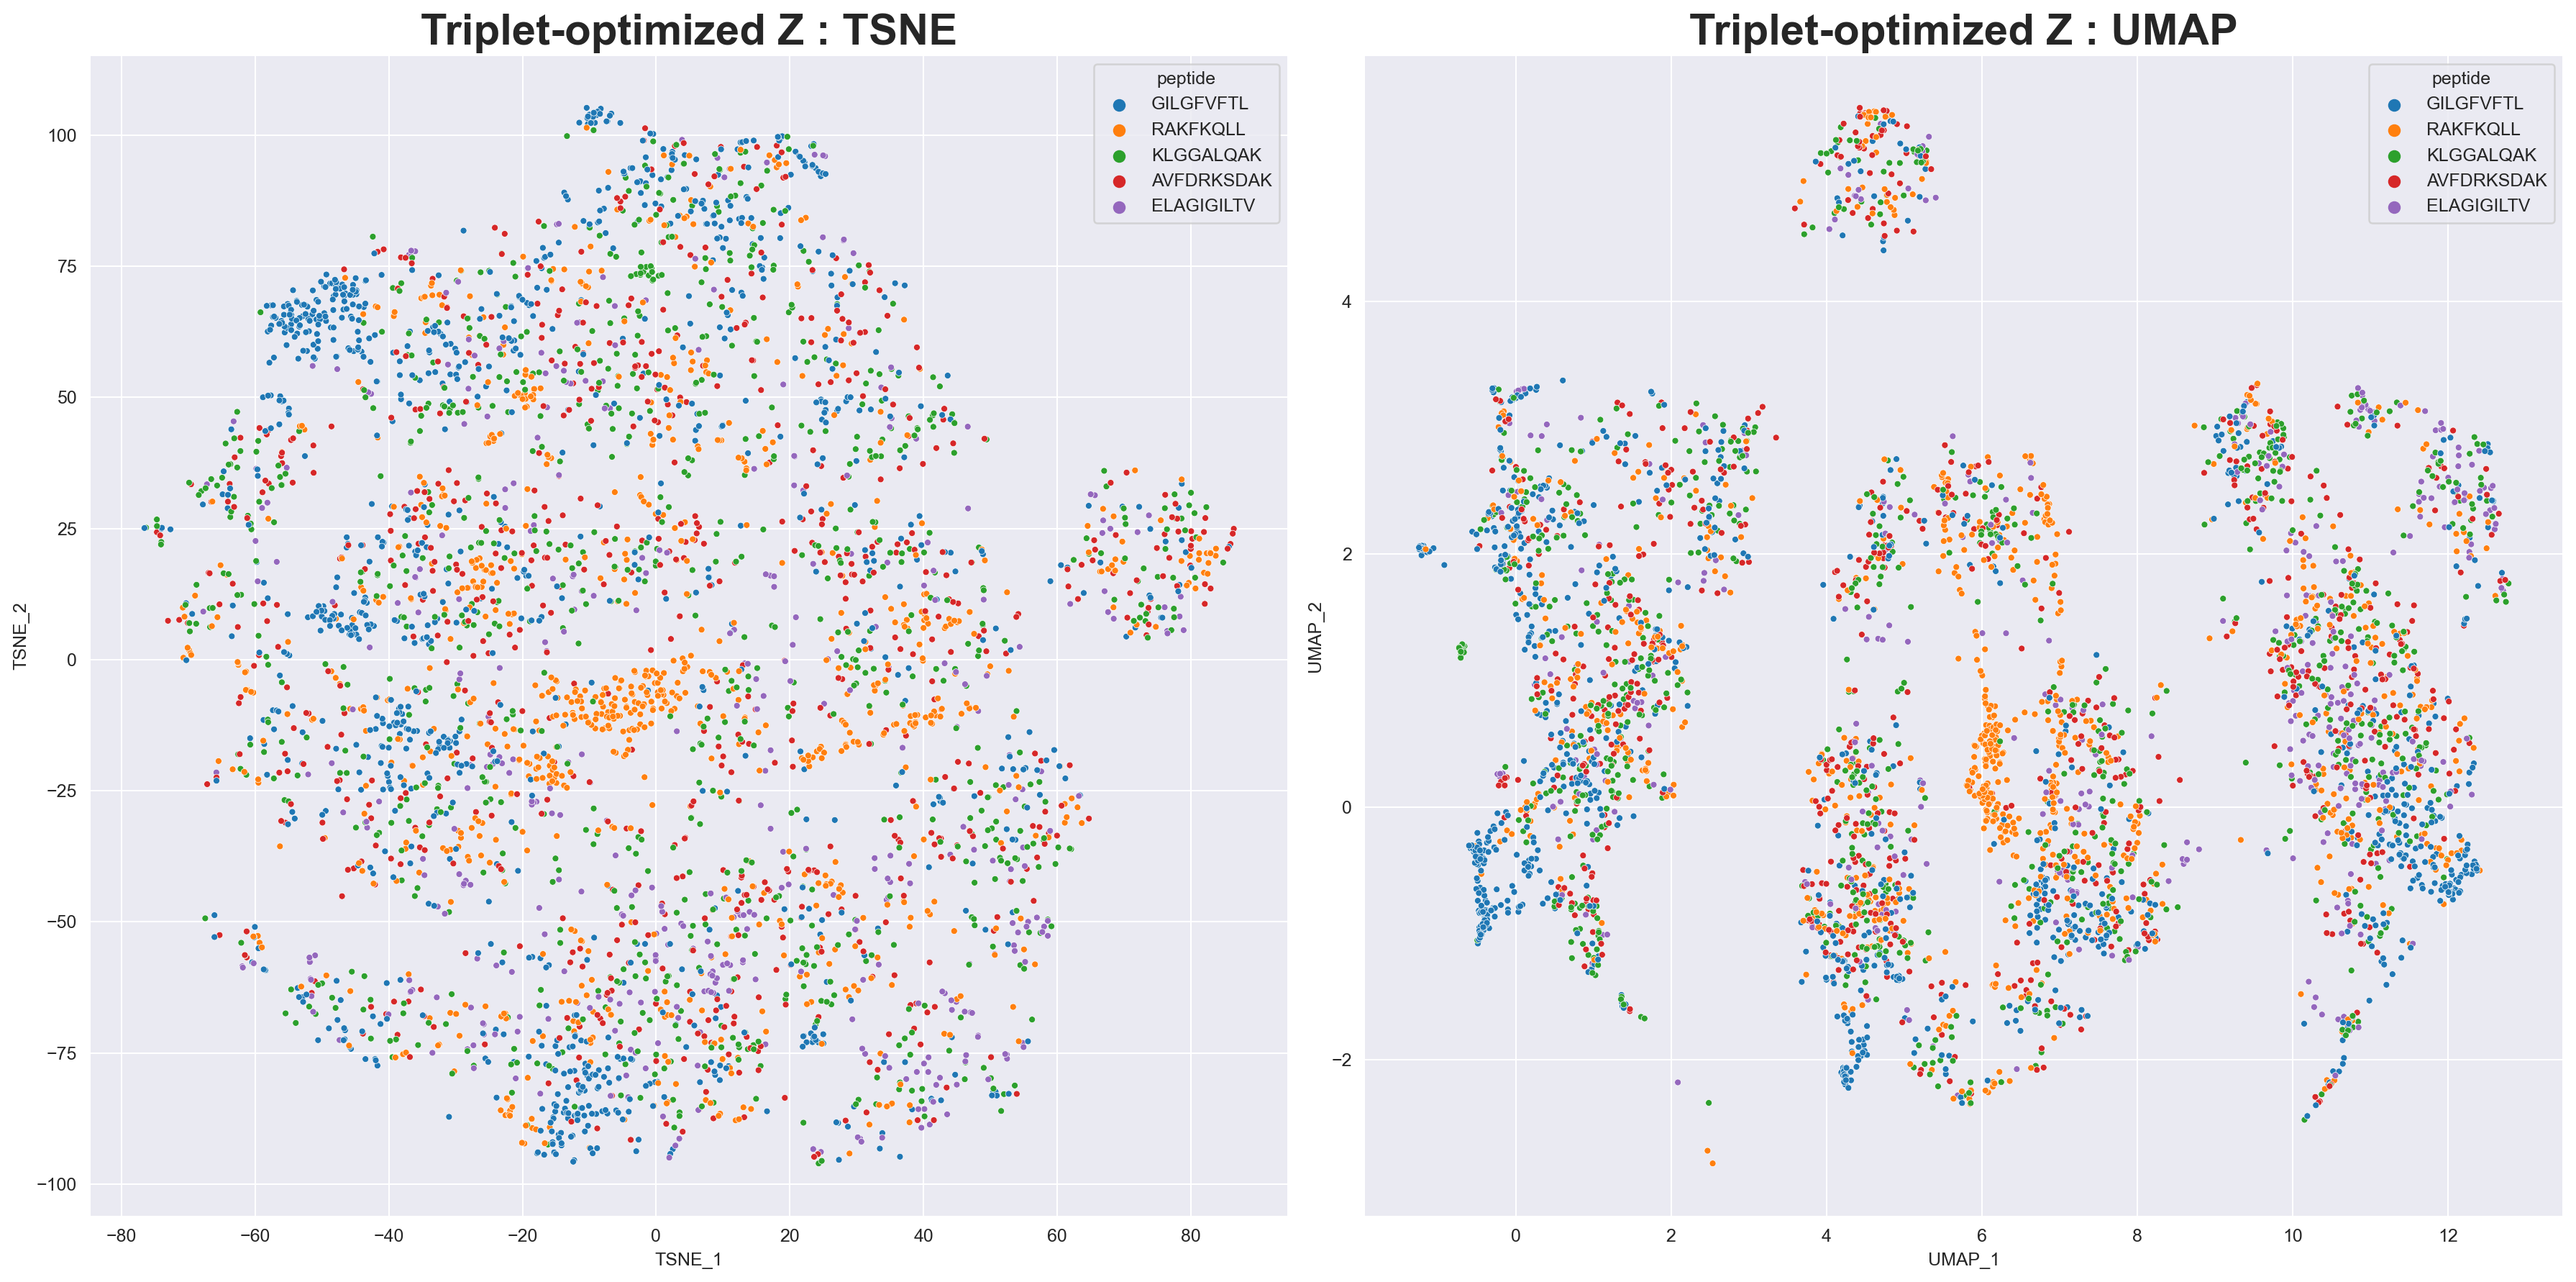

In [90]:
df[['TSNE_1', 'TSNE_2']] = latent_tsne
df[['UMAP_1', 'UMAP_2']] = latent_umap
f,a = plt.subplots(1,2, figsize=(20,10))
a = a.ravel()
top5=df.groupby('peptide').agg(count=('B3', 'count')).sort_values('count',ascending=False).head(5).index
sns.scatterplot(data=df.query('peptide in @top5'), #.query('GroundTruth!="immrep_negs"'),
                x='TSNE_1', y='TSNE_2',  s=13, hue='peptide', hue_order=top5, ax = a[0])
sns.scatterplot(data=df.query('peptide in @top5'), #.query('GroundTruth!="immrep_negs"'), 
                x='UMAP_1', y='UMAP_2',  s=13, hue='peptide', hue_order=top5, ax = a[1])

a[0].set_title('Triplet-optimized Z : TSNE', fontsize=24, fontweight='semibold')
a[1].set_title('Triplet-optimized Z : UMAP', fontsize=24, fontweight='semibold')
# a[0].legend('', frame_on=False)

# f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3', fontsize=26, fontweight='semibold')
f.tight_layout()
f.savefig('../output/TripletTest/Euclidean_Fold0Model_firstTest_TSNE_UMAP.png', dpi=200, bbox_inches='tight')


## TCRbase

In [58]:
train = dist_matrix.query('set=="train"')
valid = dist_matrix.query('label=="GILGFVFTL" and set=="valid"')


In [67]:
best = train['AMREGMEYGNKLV-ASSIFSTPNQPQH'].sort_values().head(1)
best_name = best.index[0]
best_sim = 100 - best.item()
label = train.loc[best_name]['label']

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,...,z_22,z_23,z_24,z_25,z_26,z_27,z_28,z_29,z_30,z_31
0,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,1,KLGGALQAK,KLGGALQAK,TRAV30*01,...,23.068596,-9.114511,-14.547191,7.147163,-11.286866,5.707266,16.224783,-3.529704,-0.655212,0.897752
1,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,12.889885,-8.544041,-9.618777,8.766447,-3.395038,8.932498,8.739236,3.060505,9.003555,0.673433
2,TSGFNG,NVLDGL,AVGDDKII,DFQATT,SNEGSKA,SARGLDRGTNEQY,1,AVFDRKSDAK,AVFDRKSDAK,TRAV1-2*01,...,15.008536,-2.197305,-3.549242,8.880642,-4.910419,10.289505,3.716117,2.305877,13.038246,2.639179
3,DRGSQS,IYSNGD,AVTPGTYKYI,LGHDT,YNNKEL,ASSPGTSIFVAEQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,15.999081,0.563606,-3.770080,5.421138,-1.763569,10.352894,10.224983,4.718671,9.804922,3.322605
4,TRDTTYY,RNSFDEQN,AFLYNQGGKLI,SGHDY,FNNNVP,ASSPGSRGNIQY,1,RAKFKQLL,RAKFKQLL,TRAV19*01,...,19.498362,2.709088,-8.306392,11.127001,-8.258026,7.157833,8.270676,3.846064,2.088062,2.709538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6348,TSENNYY,QEAYKQQN,AFMLGAGGTSYGKLT,LNHDA,SHIVND,ASSIGYYGYT,1,GILGFVFTL,GILGFVFTL,TRAV38-1*01,...,16.605198,3.205862,-11.238837,2.883184,-8.800512,4.853752,19.254095,-1.175071,-1.588126,2.698932
6349,DSASNY,IRSNVGE,AYGGSQGNLI,LNHDA,SQIVND,ASSFRSSETQY,1,GILGFVFTL,GILGFVFTL,TRAV13-1*01,...,12.857159,-3.139961,-11.180353,4.539649,-10.475594,7.300638,12.470460,0.332224,4.895176,-2.241735
6350,NSASDY,IRSNMDK,AENLGGGSQGNLI,LNHDA,SQIVND,ASSTRATGELF,1,GILGFVFTL,GILGFVFTL,TRAV13-2*01,...,19.321669,-2.847570,-13.938190,4.362427,-11.031135,4.445648,15.589096,0.116850,-4.121420,4.296347
6351,SSVSVY,YLSGSTLV,AVGGDGGSQGNLI,LNHDA,SQIVND,ASSIRASGVEQF,1,GILGFVFTL,GILGFVFTL,TRAV8-6*01,...,19.619366,-5.472290,-12.615619,3.873967,-9.431541,6.166322,13.243220,0.898257,-4.531645,4.764190


In [68]:
tcrbase_dissim_valid_sims = dissim_valid_gils.drop(columns=[x for x in dissim_valid_gils.columns if x != 'labels']).copy().reset_index().rename(columns={'index':'CDR3b', 'labels':'true_label'})
tcrbase_dissim_valid_sims[['similar_label', 'best_name', 'best_sim']] = tcrbase_dissim_valid_sims.apply(lambda x: get_tcrbase_method(x['CDR3b'],
                                                                                                                                     ref=dissim_train_set_gil_ref),
                                                                                                        axis=1, result_type='expand')


'ATDALMTGF'

In [56]:
# Take the validation (Gil only)
# Compare against train (All peps)
# get 1-dist as score
def get_tcrbase_method(tcr, ref):
    # here take the top1 instead of percent
    best = ref[tcr].sort_values().head(1)
    best_name = best.index[0]
    best_sim = best.item()
    label = ref.loc[best_name]['labels']
    return label, best_name, best_sim